In [1]:
import kagglehub
package = kagglehub.package_import('ryanholbrook/drawing-with-llms-getting-started-with-gemma-2/versions/9')

/home/omichi/anaconda3/envs/svgllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installing python dependencies for Package 'kagglehub_package_ryanholbrook_drawing_with_llms_getting_started_with_gemma_2_9', logging progress to '/tmp/kagglehub-package-dependencies-install-bst99r29.txt'.


In [ ]:
#| default_exp core

In [ ]:
import concurrent
import io
import logging
import re
import re2
import cairosvg
import kagglehub
import torch
import json
from collections import Counter
from lxml import etree
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):
        # Quantization Configuration
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.model_path = kagglehub.model_download('google/gemma-2/Transformers/gemma-2-9b-it/2')
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_path,
            device_map={"": 0},
            quantization_config=quantization_config,
        )

        # Base prompt template
        self.base_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width=\"256\" height=\"256\" viewBox=\"0 0 256 256\"><circle cx=\"50\" cy=\"50\" r=\"40\" fill=\"red\" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 90

    def _run_generation(self, prompt, max_new_tokens):
        inputs = self.tokenizer(text=prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            output = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
            )
        decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return decoded

    def enforce_constraints(self, svg_string: str) -> str:
        parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
        try:
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg

        to_remove = []
        for elem in root.iter():
            tag = etree.QName(elem.tag).localname
            if tag not in self.constraints.allowed_elements:
                to_remove.append(elem); continue
            # ... (attribute checks as before) ...
        for elem in to_remove:
            if elem.getparent() is not None:
                elem.getparent().remove(elem)
        try:
            return etree.tostring(root, encoding='unicode')
        except Exception:
            return self.default_svg

    def predict(self, description: str, max_new_tokens=512, method='default', **kwargs) -> str:
        """
        method: 'default' | 'cot_sc' | 'function_call' | 'ensemble'
        """
        if method == 'cot_sc':
            return self.predict_with_cot_self_consistency(description, max_new_tokens, **kwargs)
        elif method == 'function_call':
            return self.predict_with_function_calling(description, max_new_tokens)
        elif method == 'ensemble':
            return self.predict_with_ensemble(description, max_new_tokens, **kwargs)
        else:
            return self._default_predict(description, max_new_tokens)

    def _default_predict(self, description: str, max_new_tokens) -> str:
        # original generation logic
        prompt = self.base_template.format(description)
        decoded = self._run_generation(prompt, max_new_tokens)
        matches = re.findall(r"<svg.*?</svg>", decoded, re.DOTALL|re.IGNORECASE)
        svg = matches[-1] if matches else self.default_svg
        # sanitize
        return self.enforce_constraints(svg)

    def predict_with_cot_self_consistency(self, description: str, max_new_tokens=512, samples=5) -> str:
        # Chain-of-Thought prompt
        cot_prompt = self.base_template.replace(
            'Generate SVG code',
            'まずは図形分解をステップバイステップで考え、その後SVGを生成'
        ).format(description)
        svgs = []
        for _ in range(samples):
            decoded = self._run_generation(cot_prompt, max_new_tokens)
            match = re.findall(r"<svg.*?</svg>", decoded, re.DOTALL|re.IGNORECASE)
            svgs.append(match[-1] if match else self.default_svg)
        # Self-Consistency majority vote
        most_common_svg, _ = Counter(svgs).most_common(1)[0]
        return self.enforce_constraints(most_common_svg)

    def predict_with_function_calling(self, description: str, max_new_tokens=512) -> str:
        # Define function schema inline in prompt
        func_schema = {
            "create_circle": {"cx":"number","cy":"number","r":"number","fill":"string"},
            "create_rect":   {"x":"number","y":"number","width":"number","height":"number","fill":"string"}
            # ... add other primitives
        }
        prompt = (
            "Use the following JSON schema to output function calls only, then assemble into SVG:\n"
            + json.dumps(func_schema)
            + "\nDescription: '"+description+"'"
        )
        decoded = self._run_generation(prompt, max_new_tokens)
        # Parse function calls
        try:
            calls = json.loads(re.search(r"(\{.*\})", decoded, re.DOTALL).group(1))
        except Exception:
            return self.default_svg
        # Build SVG from calls
        parts = []
        for fn, params in calls.items():
            if fn == 'create_circle':
                parts.append(f"<circle cx='{params['cx']}' cy='{params['cy']}' r='{params['r']}' fill='{params.get('fill','none')}' />")
            if fn == 'create_rect':
                parts.append(f"<rect x='{params['x']}' y='{params['y']}' width='{params['width']}' height='{params['height']}' fill='{params.get('fill','none')}' />")
        svg = f"<svg viewBox='0 0 256 256' width='256' height='256'>{''.join(parts)}</svg>"
        return self.enforce_constraints(svg)

    def predict_with_ensemble(self, description: str, max_new_tokens=512, samples=10) -> str:
        # Generate multiple candidates
        candidates = []
        for _ in range(samples):
            decoded = self._run_generation(self.base_template.format(description), max_new_tokens)
            match = re.findall(r"<svg.*?</svg>", decoded, re.DOTALL|re.IGNORECASE)
            candidates.append(match[-1] if match else self.default_svg)
        # Vote for most frequent full SVG
        best_svg, _ = Counter(candidates).most_common(1)[0]
        return self.enforce_constraints(best_svg)


id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


DEBUG:bitsandbytes.cextension:Loading bitsandbytes native library from: /home/omichi/anaconda3/envs/svgllm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda124.so
Loading checkpoint shards: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]
DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="

Prediction time for description 'a purple forest at d...': 7.5540 seconds


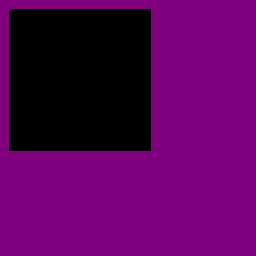

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'gray wool coat with ...': 6.2547 seconds


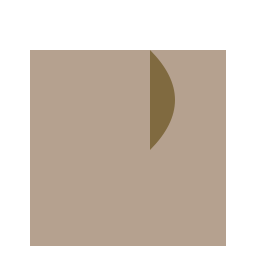

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a lighthouse overloo...': 11.3880 seconds


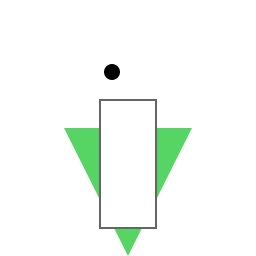

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'burgundy corduroy pa...': 10.1507 seconds


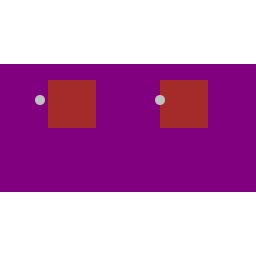

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'orange corduroy over...': 13.2319 seconds


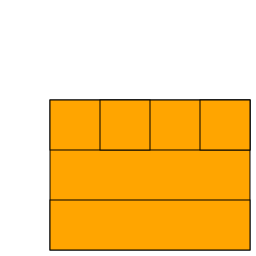

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a purple silk scarf ...': 17.0997 seconds


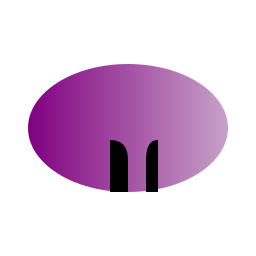

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a green lagoon under...': 11.0423 seconds


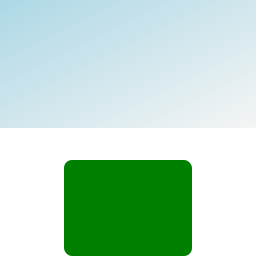

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'crimson rectangles f...': 16.5171 seconds


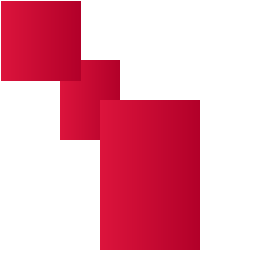

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'purple pyramids spir...': 16.6938 seconds


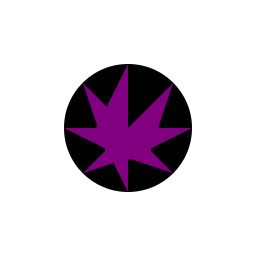

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'magenta trapezoids l...': 15.3710 seconds


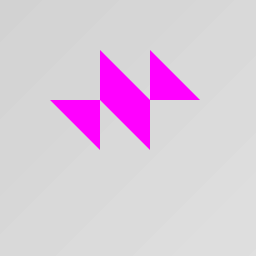

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a snowy plain...': 8.8041 seconds


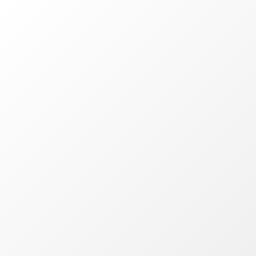

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'black and white chec...': 11.2350 seconds


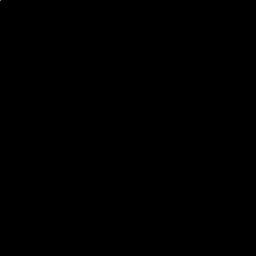

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a starlit night over...': 34.0061 seconds


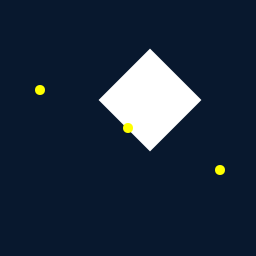

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'khaki triangles and ...': 12.7850 seconds


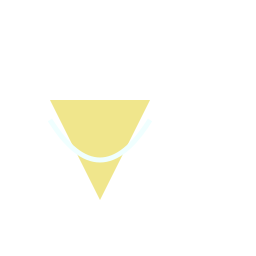

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Prediction time for description 'a maroon dodecahedro...': 32.7055 seconds


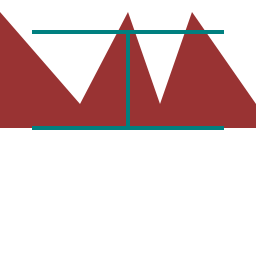

In [3]:
def generate():
    import polars as pl
    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.DEBUG, force=True)
    
    train = pl.read_csv('train.csv')
    display(train.head())
    
    model = Model()
    svgs = []
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
    
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

# Uncomment and run the line below to see some generated images
generate()

In [24]:
import kaggle_evaluation

logging.basicConfig(level=logging.INFO, force=True)
kaggle_evaluation.test(Model)

AttributeError: partially initialized module 'kaggle_evaluation' has no attribute 'core' (most likely due to a circular import)